# EEP 153 Project 1: Group Kitagawa

### **Countries of Investigation**: The Baltic States (Estonia, Latvia, and Lithuania)

**Description:**
Originally we wanted to see if there was convergence in population trends for countries who joined the EU in 2004 (mostly post-soviet states). What stood out to us most was a very similar pattern in the three Baltic states:  their populations were steadily increasing until 1994, after which they experienced a steep decline. Interested in this abnormal trend, we decided to narrow our countries of interest down to Estonia, Latvia, and Lithuania, and see what exactly caused this pattern after the fall of the USSR. Preliminary research revealed that after the USSR collapsed, these countries' healthcare systems rapidly deteriorated while poverty spiked (along with poverty, homelessness, and drug use). The combined effect was a major Tuberculosis (and HIV) epidemic around 1994. Since we only have more comprehensive data on these states starting in 1995, we decided to see how economic indicators have determined population growth and TB incidence since then. Although GDPPC is a poor measure of poverty (doesn't account for distribution), it's the most accurate indicator of poverty we have for these countries. Evidence suggests that GDPPC is strongly correlated with population, and we maintain that public health is one intermediary through which national income determines population trends.

**Objectives:**

1. Explain the impact of the dissolution of the USSR on the Baltic States
2. Analyze and create corresponding visualizations on population and socioeconomic trends relative to the fall of the USSR and the TB epidemic in the early 1990s
3. Capture any trends during the early 2000s using TB data from the World Bank python packages

## Table of contents
1. [[#A] Population DataFrames](#popdf)
2. [[#A] Population Statistics](#popstat)
    1. [Additional Statement Function](#state)      
3. [[#B&C] Population Pyramids](#poppy)
    1. [Static Pyramid](#static)
    2. [Animated Pyramid](#anim)  
4. [[#C] Population Maps of the Baltic States](#map)
5. [[#C] Other Indicators](#other)
6. [[#C] Regression: Tuberculosis and Poverty](#rg)
7. [Conclusion](#con)

## Import All Data Libraries 

In [1]:

## uncomment lines below if installation is needed 
!pip install wbdata
!pip install cufflinks
!pip install iso3166

import wbdata
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
from iso3166 import countries
import cufflinks as cf
cf.go_offline()

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [2]:
#if need be, use the comand below to get ISO alpha-3 country code 
#example:
countries.get('estonia').alpha3
countries.get('latvia').alpha3
countries.get('lithuania').alpha3

'LTU'

In [3]:
#Or, use the following command to get the country name, given its ISO3 code
#example
countries.get('EST').name

'Estonia'

For the following statistical exploration, we are using **source 40: Population estimates and projections** and a few  indicators within this database. To see all possible datasets, use `wbdata.get_source()`; to see all indicators in a dataset, use `wbdata.get_indicator(source=SOURCE_id)`.

## [#A] Population DataFrames <a name="popdf"></a>
A function that returns a `pandas` DataFrame for a particular country indexed by year, with columns giving counts of people in different age-sex groups.

**Input Parameters:**

- **sex**: a str ('Female','Male', or 'All')
- **age_range**: a tuple with a lower bound and a higher bound, between 0 to 100
- **place**: a str (the ISO 3166-1 alpha-3 code of a country or region)
- **year** (optional): an int between 1960 to 2020; if no year is specified, the returned dataframe contains statistics from 1960 to 2020

In [4]:
def population_df(sex, age_range, place, year = None):
    
    def age_generate(age_range):
        lower = 5* round(age_range[0] / 5)
        upper = 5* round(age_range[1] / 5)
        age_code = []
        while lower < upper and lower < 80:
            age_code.append(f"{lower:02d}{lower+4:02d}")
            lower += 5
        if upper > 79:
            age_code.append('80UP')
        return age_code
        
    age_list = age_generate(age_range)
    
    def label_generate(sex, age_ls):
        prefix = sex[:2].upper()
        indicators = {}
        for i in range(len(age_ls)):
            indicators[f"SP.POP.{age_ls[i]}.{prefix}"] = f"{sex} ages {age_ls[i][:2]}-{age_ls[i][2:4]}"
        return indicators
    
    if sex != "All":
        indicator_labels = label_generate(sex, age_list)
    else:
        male_labels = label_generate("Male", age_list)
        female_labels = label_generate("Female", age_list)
        
        male_labels.update(female_labels)
        indicator_labels = male_labels
    
    pdf = wbdata.get_dataframe(indicator_labels, country = place)
    
    def clean_df(df, year = None):
        df.reset_index(inplace=True)
        df['date'] = df['date'].astype(int) 
        df.set_index('date', inplace = True)
        df['Total Population in Given Range'] = df.loc[:].sum(axis=1)
        if year != None:
            df.query(f'date=={year}', inplace = True)
            
    clean_df(pdf, year)
    return pdf

**One testing example:**

In [5]:
world_female = population_df("Female", (47,100), "WLD", year = 2002)
world_female 

,Female ages 45-49,Female ages 50-54,Female ages 55-59,Female ages 60-64,Female ages 65-69,Female ages 70-74,Female ages 75-79,Female ages 80-UP,Total Population in Given Range
date,,,,,,,,,
2002,172436167.0,144642454.0,111974477.0,96861604.0,83341490.0,66225590.0,48357921.0,50298053.0,774137756.0


### 1.Population Tabulation for Estonia

In [6]:
estonia = population_df("All", (1,100), "EST")
estonia

,Male ages 00-04,Male ages 05-09,Male ages 10-14,Male ages 15-19,Male ages 20-24,Male ages 25-29,Male ages 30-34,Male ages 35-39,Male ages 40-44,Male ages 45-49,...,Female ages 40-44,Female ages 45-49,Female ages 50-54,Female ages 55-59,Female ages 60-64,Female ages 65-69,Female ages 70-74,Female ages 75-79,Female ages 80-UP,Total Population in Given Range
date,,,,,,,,,,,,,,,,,,,,,
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020,35955.0,38207.0,38866.0,32086.0,29666.0,46429.0,53894.0,47694.0,45834.0,49185.0,...,43041.0,47508.0,39096.0,46754.0,47282.0,49451.0,32731.0,36274.0,58673.0,1331060.0
2019,35743.0,38648.0,38094.0,30917.0,31675.0,47720.0,53040.0,46754.0,46441.0,47285.0,...,43813.0,46207.0,40161.0,47497.0,48013.0,46798.0,33582.0,36135.0,57184.0,1326899.0
2018,34999.0,39377.0,36908.0,29869.0,34090.0,48714.0,51707.0,46136.0,47221.0,44763.0,...,44849.0,44370.0,42117.0,47681.0,48711.0,43915.0,34982.0,35906.0,55565.0,1321977.0
2017,34419.0,39930.0,35509.0,29256.0,36343.0,49672.0,50112.0,45845.0,47711.0,42507.0,...,45701.0,42799.0,44239.0,47757.0,48784.0,41924.0,35841.0,36110.0,53696.0,1317383.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,50217.0,49909.0,50254.0,48789.0,44629.0,52926.0,49113.0,45928.0,30396.0,24949.0,...,47361.0,34924.0,46112.0,44101.0,40546.0,34178.0,26836.0,19395.0,16906.0,1277083.0
1963,49920.0,49550.0,49847.0,46057.0,45889.0,51739.0,48961.0,42656.0,27900.0,26256.0,...,43257.0,36964.0,46153.0,43593.0,39678.0,33274.0,26310.0,18934.0,16462.0,1258856.0
1962,49498.0,49221.0,49164.0,43385.0,47756.0,50167.0,48892.0,38997.0,25979.0,28080.0,...,39105.0,40014.0,45573.0,43164.0,38830.0,32497.0,25925.0,18495.0,15883.0,1241625.0


### 2.Population Tabulation for Latvia 

In [7]:
latvia = population_df("All", (1,100), "LVA")
latvia

,Male ages 00-04,Male ages 05-09,Male ages 10-14,Male ages 15-19,Male ages 20-24,Male ages 25-29,Male ages 30-34,Male ages 35-39,Male ages 40-44,Male ages 45-49,...,Female ages 40-44,Female ages 45-49,Female ages 50-54,Female ages 55-59,Female ages 60-64,Female ages 65-69,Female ages 70-74,Female ages 75-79,Female ages 80-UP,Total Population in Given Range
date,,,,,,,,,,,,,,,,,,,,,
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020,59925.0,49127.0,52985.0,44197.0,36453.0,61794.0,73341.0,61917.0,60104.0,65153.0,...,61626.0,69069.0,63062.0,79216.0,73811.0,73039.0,48278.0,60901.0,81037.0,1901548.0
2019,58850.0,50228.0,52323.0,42416.0,40800.0,65950.0,72516.0,61746.0,61515.0,64440.0,...,63369.0,68405.0,65722.0,79230.0,73982.0,68519.0,51092.0,59146.0,82141.0,1913822.0
2018,55814.0,52010.0,51139.0,41015.0,46700.0,69232.0,71254.0,62184.0,63329.0,63244.0,...,65426.0,67246.0,69543.0,78401.0,74428.0,63818.0,55618.0,56812.0,83146.0,1927174.0
2017,52243.0,53552.0,49810.0,40618.0,53107.0,71707.0,70146.0,62868.0,65176.0,62350.0,...,67425.0,66490.0,73311.0,77687.0,74020.0,60780.0,59544.0,55888.0,82930.0,1942249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,88837.0,86560.0,82018.0,78943.0,86033.0,91040.0,86198.0,77874.0,51448.0,41289.0,...,85169.0,58620.0,82839.0,77779.0,71231.0,56381.0,44667.0,32341.0,30683.0,2240627.0
1963,88274.0,85297.0,79586.0,78689.0,86497.0,89092.0,85364.0,72389.0,46610.0,44442.0,...,76476.0,63247.0,82848.0,77347.0,68834.0,54805.0,43760.0,31531.0,30174.0,2210919.0
1962,87265.0,83712.0,77203.0,79005.0,86663.0,87172.0,84378.0,66355.0,42679.0,48802.0,...,67559.0,70022.0,81558.0,76984.0,66245.0,53637.0,43007.0,30847.0,29382.0,2181585.0


### 3.Population Tabulation for Lithuania  

In [8]:
lithuania = population_df("All", (1,100), "LTU")
lithuania

,Male ages 00-04,Male ages 05-09,Male ages 10-14,Male ages 15-19,Male ages 20-24,Male ages 25-29,Male ages 30-34,Male ages 35-39,Male ages 40-44,Male ages 45-49,...,Female ages 40-44,Female ages 45-49,Female ages 50-54,Female ages 55-59,Female ages 60-64,Female ages 65-69,Female ages 70-74,Female ages 75-79,Female ages 80-UP,Total Population in Given Range
date,,,,,,,,,,,,,,,,,,,,,
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020,76730.0,82275.0,63163.0,64723.0,70274.0,98520.0,99409.0,80264.0,82258.0,96679.0,...,83208.0,103231.0,99414.0,131402.0,108258.0,102640.0,71714.0,79711.0,127154.0,2794701.0
2019,76760.0,77629.0,62751.0,66162.0,77620.0,101721.0,95743.0,80006.0,85182.0,95768.0,...,87653.0,102864.0,104592.0,128045.0,106197.0,96053.0,73224.0,78193.0,125227.0,2794137.0
2018,76790.0,73484.0,63697.0,68381.0,85933.0,102728.0,92092.0,80930.0,88342.0,94190.0,...,92309.0,101611.0,111287.0,122793.0,105212.0,89487.0,76694.0,76341.0,123142.0,2801542.0
2017,77383.0,70874.0,65379.0,72512.0,94239.0,102309.0,89762.0,82844.0,91505.0,93784.0,...,96909.0,101579.0,117536.0,118488.0,103797.0,85426.0,80225.0,76104.0,120407.0,2828402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,146762.0,139478.0,121031.0,112532.0,114613.0,113025.0,111993.0,99662.0,70751.0,48724.0,...,98335.0,68121.0,85918.0,84095.0,75382.0,60675.0,42778.0,31363.0,26508.0,2935203.0
1963,146367.0,135523.0,118956.0,113720.0,114455.0,112854.0,111100.0,94795.0,64604.0,48656.0,...,89447.0,71179.0,86793.0,83196.0,73933.0,58085.0,42223.0,29948.0,25226.0,2898949.0
1962,145534.0,131777.0,117513.0,115215.0,113574.0,112956.0,109658.0,89288.0,58905.0,50022.0,...,80517.0,76269.0,86542.0,82309.0,72388.0,55619.0,41961.0,28176.0,24096.0,2863351.0


## [#A] Population Statistics <a name="popstat"></a>

Using the previously defined `population_df` function, a `python` function named `population` is created to return the population in a particular country in a given age range for a given year.


**Input Parameters:**

- **year**: a int between 1960 to 2020
- **sex**: a str ('Female','Male', or 'All')
- **age_range**: a tuple with a lower bound and a higher bound, between 0 to 100
- **place**: a str (the ISO 3166-1 alpha-3 code of a country or region)

In [9]:
def population(year_defined, sex, age_range, place):
    df = population_df(sex, age_range, place, year = year_defined)
    population = df['Total Population in Given Range'].loc[year_defined]       
    return population


**One testing examples:**

In [10]:
population(2002, "Female", (47,100), "WLD")

774137756.0

### 1.Population of  Estonia in 1990

In [11]:
population(1990,"All", (1,100), "EST")

1569173.0

### 2.Population of  Latvia in 1990

In [12]:
population(1990,"All", (1,100), "LVA")

2663151.0

### 3.Population of  Lithuania in 1990

In [13]:
population(1990,"All", (1,100), "LTU")

3697836.0

### Additional Statement Function <a name="state"></a>
In additin, a `python` function named `population_statement` is created to return a string with population statistics in the following form:

- In [year], there are [number] of [people/males/females] aged [low] to [high] living in [the world/region/country].


**Input Parameters:**
- **year**: a int between 1960 to 2020
- **sex**: a str ('Female','Male', or 'All')
- **age_range**: a tuple with a lower bound and a higher bound, between 0 to 100
- **place**: a str (the ISO 3166-1 alpha-3 code of a country or region)

In [14]:
def population_statement(year_defined, sex, age_range, place):
    df = population_df(sex, age_range, place, year = year_defined)
    if sex == "All":
        ppl = 'people'
    else:
        ppl = f"{sex.lower()}s"
    lower = age_range[0]
    higher = age_range[1]
    if place == 'WLD':
        country_name = 'the world'
    else:
        country_name = countries.get(place).name
    population = df['Total Population in Given Range'].loc[year_defined]
    
    answer = f"In {year_defined}, there are {population} {ppl} aged {lower} to {higher} living in {country_name} by approximation."
    
    return answer

**One testing examples:**

In [15]:
population_statement(2002, "Female", (47,100), "WLD")

'In 2002, there are 774137756.0 females aged 47 to 100 living in the world by approximation.'

## [#B&C] Population Pyramids <a name="poppy"></a>

### Static Population Pyramid Function <a name="static"></a>
The `pop_pyramid` function returns a static population pyramid for either the population of a single year or the populations between a year range with a specified increment of years. 

**Input Parameters:**
- **dataframe**: the name of the established dataframe for a specific country 
- **country_name**: A string (e.g. "Estonia")
- **year**: a list
    - for a single year, it's in the form [year]
    - for multiple years, it's in the form [end_year, start_year, year_increments] 


In [16]:
def pop_pyramid(dataframe, country_name, year):
    py.init_notebook_mode(connected=True)
    
    #create titles for the two different forms of population pyramid
    def title_creator(country_name, year):
        if len(year) == 1:
            title = f"Population Pyramid of {country_name}, {year[0]}"    
        else:
            "Population Pyramid of Estonia, 1990-2010"
            title = f"Population Pyramid of {country_name}, {year[1]}-{year[0]} ({year[2]}-year Increments)"
        return title 
    title_ = title_creator(country_name, year)
    
    layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Population'),
                  title = title_)
    
    #create the age labels 
    age_ranges = []
    for i in range(0,80,5):
        age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
    age_ranges.append("80UP")
    
    #bins for one year 
    if len(year) == 1:
        bins = [go.Bar(x = dataframe.loc[year[0],:].filter(regex="Male").values,
                   y = [int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Men',
                   marker=dict(color='blue'),
                   hoverinfo=['x','y']
                   ),
                go.Bar(x = -dataframe.loc[year[0],:].filter(regex="Female").values,
                   y=[int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Women',
                   marker=dict(color='red'),
                   hoverinfo=['x','y']
                      )
               ]
    #bins for multiple years 
    else:
        years = range(year[0],year[1], -year[2])
        bins = [go.Bar(x = dataframe.loc[year,:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men {:d}'.format(year),
               hoverinfo=['x','y'],
                 opacity=0.5, 
                 marker=dict(color='green')
              )
        for year in years]
          
        bins += [go.Bar(x = -dataframe.loc[year,:].filter(regex="Female").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo=['x','y'],
                  opacity=0.5,
                  marker=dict(color='orange')
               )
         for year in years]

        
    py.iplot(dict(data=bins, layout=layout))
    

### Animated Population Pyramid Function <a name="anim"></a>
The `animate_pyramid` function returns an interactive population pyramid for the chosen country to illustrate the change of population over years.

**Input Parameters:**
- **df**: the name of the established dataframe for a specific country 
- **country_name**: A string (e.g. "Estonia")
- **year**: a tuple
    - in the form (star_year, end_year, year_increments) 


In [17]:
#import data libraries 
import ipywidgets
from ipywidgets import interactive, fixed

def animate_pyramid(df, country_name, year):
    def animate_helper(df, country_name, year):
            py.init_notebook_mode(connected=True)
            
            age_ranges = []
            for i in range(0,80,5):
                age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
            age_ranges.append("80UP")
            
            layout = go.Layout(barmode='overlay',
                               yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                               xaxis=go.layout.XAxis(title='Population'),
                               title = f"Population Pyramid of {country_name}, {year}")
            bins = [go.Bar(x = df.loc[year,:].filter(regex="Male").values,
                           y = [int(s[:2])+1 for s in age_ranges],
                           orientation='h',
                           name='Men',
                           marker=dict(color='yellow'),
                           hoverinfo=['x','y']
                          ),
                    go.Bar(x = -df.loc[year,:].filter(regex="Female").values,
                           y=[int(s[:2])+1 for s in age_ranges],
                           orientation='h',
                           name='Women',
                           marker=dict(color='pink'),
                           hoverinfo=['x','y'])
                   ]
            py.iplot(dict(data=bins, layout=layout))
    return ipywidgets.interactive(animate_helper, df = fixed(df), year = year, country_name = country_name)


### 1. Estonia 

In [18]:
pop_pyramid(estonia, "Estonia", [2010])
pop_pyramid(estonia, "Estonia", [2020,1960,20])
animate_pyramid(estonia, "Estonia", (1960, 2020, 1))

interactive(children=(Text(value='Estonia', description='country_name'), IntSlider(value=1990, description='ye…

### 2. Latvia  

In [19]:
pop_pyramid(latvia, "Latvia", [2010])
pop_pyramid(latvia, "Latvia", [2020,1960,20])
animate_pyramid(latvia, "Latvia", (1960, 2020, 1))

interactive(children=(Text(value='Latvia', description='country_name'), IntSlider(value=1990, description='yea…

### 3. Lithuania 

**Population Pyramid from 1990 to 2010 (5-year Increments)**

In [20]:
pop_pyramid(lithuania, "Lithuania", [2010])
pop_pyramid(lithuania, "Lithuania", [2020,1960,20])
animate_pyramid(lithuania, "Lithuania", (1960, 2020, 1))

interactive(children=(Text(value='Lithuania', description='country_name'), IntSlider(value=1990, description='…

## [#C] Population Maps of the Baltic States <a name="map"></a>



In [21]:
# Install & import new data libraries 
!pip install geopandas
!pip install pyshp


import matplotlib.pyplot as plt
import geopandas as gpd
import shapefile as shp
import seaborn as sns

We now import the shapefiles for the Baltic States and create a dataframe with the shapefile information. We extracted the shapefiles for Estonia, Lithuania, and Latvia from a large European map in QGIS.

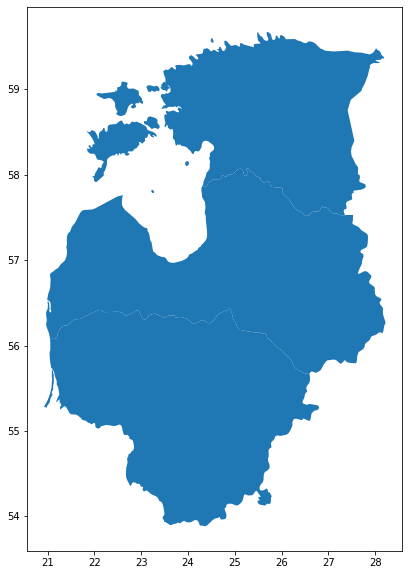

In [22]:
baltics_path = "/home/jovyan//EEP153_Exercises/Baltics Shapefiles"
map_df = gpd.read_file(baltics_path)
plt.rcParams['figure.figsize'] = [30,10]
map_df.plot();

We plan on creating a population density map so we will create a dataframe using the wbdata package for population for the three Baltic States.

In [23]:
population = {"SP.POP.TOTL":"Population"}
baltic = {"EST":"Estonia",
            "LVA":"Latvia",
            "LTU":"Lithuania"}

# The following creates a dataframe for population in the Baltic States
baltic_pop_df = wbdata.get_dataframe(population, country=baltic).squeeze()
baltic_pop_df = baltic_pop_df.unstack('country')
baltic_pop_df.index = baltic_pop_df.index.astype(int)
baltic_pop_df = baltic_pop_df.transpose()
baltic_pop_df.index.name
map_df.index.name
# Now we merge the population dataframe with the map dataframe.
pop_map_df = map_df.merge(baltic_pop_df, left_on="NAME_ID", right_on="country", how='outer')
pop_map_df

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Admin-0 map unit,0.0,5.0,Lithuania,LTU,0.0,2.0,Sovereign country,Lithuania,LTU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Admin-0 map unit,0.0,6.0,Estonia,EST,0.0,2.0,Sovereign country,Estonia,EST,...,1327439.0,1322696.0,1317997.0,1314545.0,1315407.0,1315790.0,1317384.0,1321977.0,1326898.0,1331057.0
2,Admin-0 map unit,0.0,5.0,Latvia,LVA,0.0,2.0,Sovereign country,Latvia,LVA,...,2059709.0,2034319.0,2012647.0,1993782.0,1977527.0,1959537.0,1942248.0,1927174.0,1913822.0,1901548.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3028115.0,2987773.0,2957689.0,2932367.0,2904910.0,2868231.0,2828403.0,2801543.0,2794137.0,2794700.0


Now we make a new dataframe extracting only the information we want to use from the shapefiles dataframe for clean and easy manipulation before merging the new shapefiles dataframe with the population dataframe.

In [24]:
shape_columns = map_df[['SOVEREIGNT', 'ADMIN', 'geometry']]
merged = shape_columns.merge(baltic_pop_df, left_on="SOVEREIGNT", right_on="country", how='outer')
merged

,SOVEREIGNT,ADMIN,geometry,1960,1961,1962,1963,1964,1965,1966,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Lithuania,Lithuania,"MULTIPOLYGON (((26.59453 55.66699, 26.60383 55...",2778550.0,2823550.0,2863350.0,2898950.0,2935200.0,2971450.0,3008050.0,...,3028115.0,2987773.0,2957689.0,2932367.0,2904910.0,2868231.0,2828403.0,2801543.0,2794137.0,2794700.0
1,Estonia,Estonia,"MULTIPOLYGON (((24.30616 57.86819, 24.31666 57...",1211537.0,1225077.0,1241623.0,1258857.0,1277086.0,1294566.0,1308597.0,...,1327439.0,1322696.0,1317997.0,1314545.0,1315407.0,1315790.0,1317384.0,1321977.0,1326898.0,1331057.0
2,Latvia,Latvia,"POLYGON ((27.35293 57.52760, 27.52817 57.52848...",2120979.0,2152681.0,2181586.0,2210919.0,2240623.0,2265919.0,2283217.0,...,2059709.0,2034319.0,2012647.0,1993782.0,1977527.0,1959537.0,1942248.0,1927174.0,1913822.0,1901548.0


In [25]:
# Set a common index to match series
merged = merged.set_index('SOVEREIGNT')

In [26]:
# Create a series with the land areas (km^2) of the Baltic States.
landareas = pd.Series([25212, 17505, 24938], index = ['Lithuania', 'Estonia', 'Latvia'])
landareas

Lithuania    25212
Estonia      17505
Latvia       24938
dtype: int64

Next, we are dividing the population columns in the dataframe by the land areas of the Baltic states to create an interactive population density map.

In [27]:
for n in range(1960,2021,1):
    merged[n] = merged[n] / landareas
merged

,ADMIN,geometry,1960,1961,1962,1963,1964,1965,1966,1967,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
SOVEREIGNT,,,,,,,,,,,,,,,,,,,,,
Lithuania,Lithuania,"MULTIPOLYGON (((26.59453 55.66699, 26.60383 55...",110.207441,111.992305,113.570919,114.982945,116.420752,117.858559,119.310249,120.752023,...,120.106100,118.505989,117.312748,116.308385,115.219340,113.764517,112.184793,111.119427,110.825678,110.848009
Estonia,Estonia,"MULTIPOLYGON (((24.30616 57.86819, 24.31666 57...",69.210911,69.984404,70.929620,71.914139,72.955498,73.954070,74.755613,75.346815,...,75.831991,75.561040,75.292602,75.095401,75.144644,75.166524,75.257584,75.519966,75.801085,76.038675
Latvia,Latvia,"POLYGON ((27.35293 57.52760, 27.52817 57.52848...",85.050084,86.321317,87.480391,88.656628,89.847742,90.862098,91.555738,92.277649,...,82.593191,81.575066,80.706031,79.949555,79.297738,78.576349,77.883070,77.278611,76.743203,76.251023


Now we can graph the population density in the Baltic countries by specifying the year we want to see.

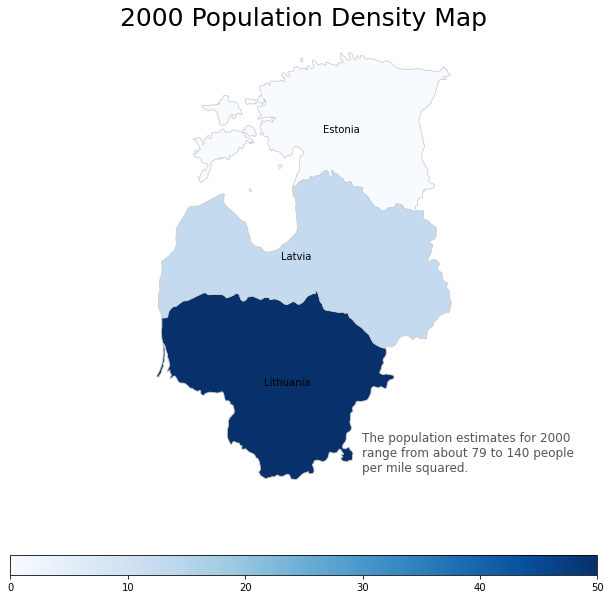

In [28]:
variable = 2000
vmin, vmax = 0, 50
fig, ax = plt.subplots(1, figsize=(30,10))
ax.axis('off')
ax.set_title('2000 Population Density Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('The population estimates for 2000 \nrange from about 79 to 140 people \nper mile squared. ',xy=(26, 54),
            xycoords='data', fontsize=12, 
            color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
for idx, row in merged.iterrows():
    plt.annotate(text=row['ADMIN'], xy=row['coords'],horizontalalignment='center')

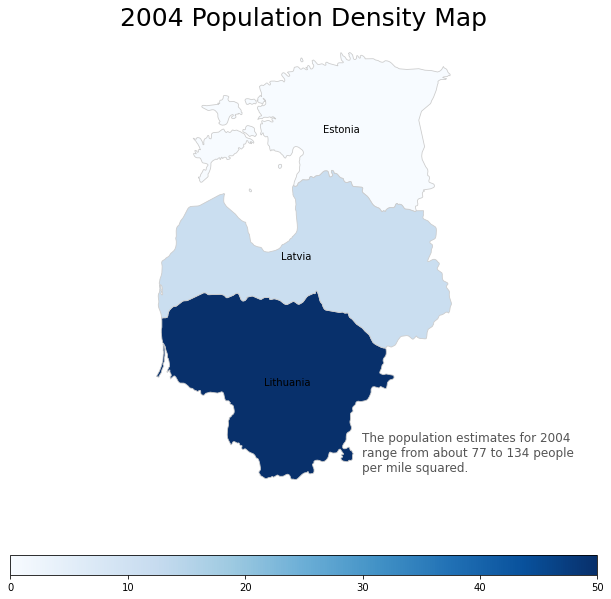

In [29]:
variable = 2004
vmin, vmax = 0, 50
fig, ax = plt.subplots(1, figsize=(30,10))
ax.axis('off')
ax.set_title('2004 Population Density Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('The population estimates for 2004 \nrange from about 77 to 134 people \nper mile squared. ',xy=(26, 54),
            xycoords='data', fontsize=12, 
            color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
for idx, row in merged.iterrows():
    plt.annotate(text=row['ADMIN'], xy=row['coords'],horizontalalignment='center')

We also want to visualize TB rates on the density map so we will create a dataframe for TB Incidence using the World Bank Data package.

In [30]:
#TB Rates 
tb_incidence_df = wbdata.get_dataframe({"SH.TBS.INCD":"Incidence of tuberculosis (per 100,000 people)"}, country = baltic)
tb_incidence_df = tb_incidence_df.squeeze().T.unstack('country').dropna(axis=0, how='any')
tb_incidence_df.index = tb_incidence_df.index.astype(int)
tb_incidence_df = tb_incidence_df.T
tb_incidence_df = shape_columns.merge(tb_incidence_df, left_on="SOVEREIGNT", right_on="country", how='outer')
tb_incidence_df

,SOVEREIGNT,ADMIN,geometry,2000,2001,2002,2003,2004,2005,2006,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Lithuania,Lithuania,"MULTIPOLYGON (((26.59453 55.66699, 26.60383 55...",87.0,86.0,81.0,88.0,69.0,73.0,82.0,...,65.0,62.0,60.0,57.0,55.0,54.0,51.0,44.0,42.0,29.0
1,Estonia,Estonia,"MULTIPOLYGON (((24.30616 57.86819, 24.31666 57...",65.0,59.0,52.0,49.0,45.0,41.0,36.0,...,25.0,23.0,23.0,21.0,18.0,16.0,15.0,13.0,13.0,10.0
2,Latvia,Latvia,"POLYGON ((27.35293 57.52760, 27.52817 57.52848...",96.0,98.0,89.0,84.0,80.0,72.0,67.0,...,47.0,53.0,49.0,42.0,40.0,37.0,32.0,29.0,26.0,23.0


We can now create the density maps with the TB dataframe.

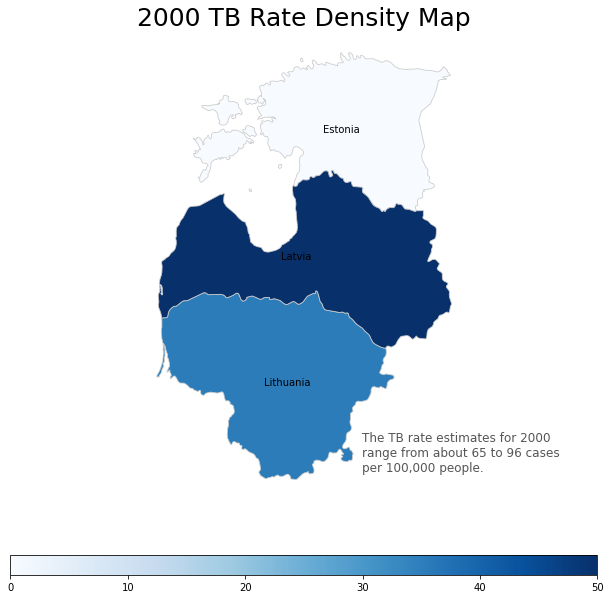

In [31]:
variable = 2000
vmin, vmax = 0, 50
fig, ax = plt.subplots(1, figsize=(30,10))
ax.axis('off')
ax.set_title('2000 TB Rate Density Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('The TB rate estimates for 2000 \nrange from about 65 to 96 cases \nper 100,000 people. ',xy=(26, 54),
            xycoords='data', fontsize=12, 
            color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
tb_incidence_df.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
tb_incidence_df['coords'] = tb_incidence_df['geometry'].apply(lambda x: x.representative_point().coords[:])
tb_incidence_df['coords'] = [coords[0] for coords in tb_incidence_df['coords']]
for idx, row in merged.iterrows():
    plt.annotate(text=row['ADMIN'], xy=row['coords'],horizontalalignment='center')

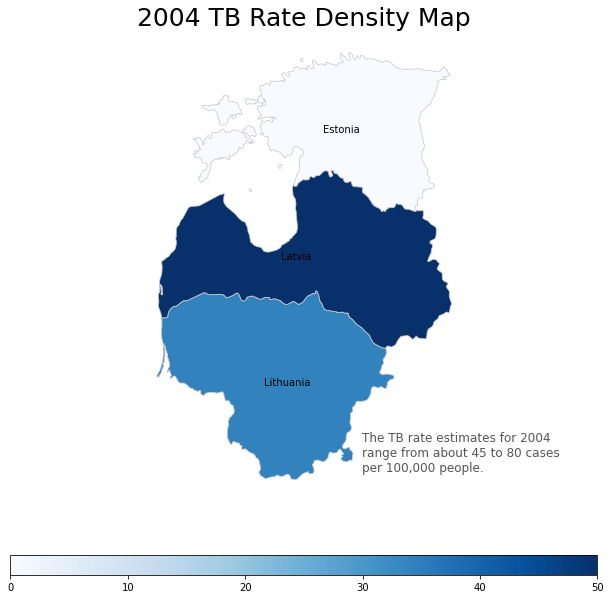

In [32]:
variable = 2004
vmin, vmax = 0, 50
fig, ax = plt.subplots(1, figsize=(30,10))
ax.axis('off')
ax.set_title('2004 TB Rate Density Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('The TB rate estimates for 2004 \nrange from about 45 to 80 cases \nper 100,000 people. ',xy=(26, 54),
            xycoords='data', fontsize=12, 
            color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
tb_incidence_df.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
tb_incidence_df['coords'] = tb_incidence_df['geometry'].apply(lambda x: x.representative_point().coords[:])
tb_incidence_df['coords'] = [coords[0] for coords in tb_incidence_df['coords']]
for idx, row in merged.iterrows():
    plt.annotate(text=row['ADMIN'], xy=row['coords'],horizontalalignment='center')

## [#C] Other Indicators <a name="other"></a>

The following cell creates dictionaries for the members of the Baltics, the original EU members in 1995 before the other 12 countries joined to form the entire EU which is also listed below.

In [33]:
baltic = {"EST":"Estonia",
                "LVA":"Latvia",
                "LTU":"Lithuania"
         }

original_15 = {"ESP":"Spain",
                "AUT":"Austria",
                "FIN":"Finland",
                "GRC":"Greece",
                "PRT":"Portugal",
                "IRL":"Ireland",
                "DNK":"Denmark",
                "SWE":"Sweden",
                "BEL":"Belgium",
                "FRA":"France",
                "DEU":"Germany",
                "ITA":"Italy",
                "LUX":"Luxembourg",
                "NLD":"The Netherlands",
                "GBR":"United Kingdom"
                 }

eumembers = {"ESP":"Spain",
                "AUT":"Austria",
                "EST":"Estonia",
                "FIN":"Finland",
                "GRC":"Greece",
                "LVA":"Latvia",
                "LTU":"Lithuania",
                "MLT":"Malta",
                "POL":"Poland",
                "PRT":"Portugal",
                "SVK":"Slovakia",
                "SVN":"Slovenia",
                "IRL":"Ireland",
                "BGR":"Bulgaria",
                "HRV":"Croatia",
                "ROU":"Romania",
                "CZE":"Czech Republic",
                "DNK":"Denmark",
                "HUN":"Hungary",
                "POL":"Poland",
                "SWE":"Sweden",
                "BEL":"Belgium",
                "CYP":"Cyprus",
                "FRA":"France",
                "DEU":"Germany",
                "ITA":"Italy",
                "LUX":"Luxembourg",
                "NLD":"The Netherlands" 
                 }

We created 4 functions for graphing hte different indicators. The first one graphs a given indicator for certain countries. The second one  graphs the log of a given indicator for certain countries. The last 2 graph either the indicator or the log of the indicator, but also graph 2 more lines for EU15 (the original 15 members of the EU) and one for EU27 (all current members of the EU) which contain the average in all of those countries combined.

In [34]:
import plotly.graph_objs as go

def graph_indicator(indicator_dict, country_dict, graph_title, y_title):
    data = wbdata.get_dataframe(indicator_dict, country = country_dict).squeeze().T
    data = data.unstack('country').dropna(axis=0, how='any')
    data.index = data.index.astype(int)
    data.iplot(title = graph_title,
                        yTitle = y_title, xTitle = 'Year')
    
def graph_log(indicator_dict, country_dict, graph_title, y_title):
    data = wbdata.get_dataframe(indicator_dict, country = country_dict).squeeze().T
    data = data.unstack('country').dropna(axis=0, how='any')
    data.index = data.index.astype(int)
    np.log(data).diff().iplot(title = graph_title,
                        yTitle = y_title, xTitle = 'Year')
    
def eu_comparison_graph(indicator_dict, graph_title, y_title):
    all_eu = wbdata.get_dataframe(indicator_dict, country = eumembers)
    all_eu = all_eu.unstack('country').dropna(axis=0, how='any').droplevel(level=0, axis = 1)
    all_eu['EU27'] = all_eu.sum(axis=1) / 27
    
    originals = wbdata.get_dataframe(indicator_dict, country = original_15)
    originals = originals.unstack('country').dropna(axis=0, how='any').droplevel(level=0, axis = 1)
    all_eu['EU15'] = originals.sum(axis=1) / 15
    all_eu.index = all_eu.index.astype(int)
    
    comparison = all_eu[['Estonia', 'Latvia', 'Lithuania', 'EU27', 'EU15']]
    comparison.iplot(title = graph_title,
                        yTitle = y_title, xTitle = 'Year')
    
def eu_log_comparison_graph(indicator_dict, graph_title, y_title):
    all_eu = wbdata.get_dataframe(indicator_dict, country = eumembers)
    all_eu = all_eu.unstack('country').dropna(axis=0, how='any').droplevel(level=0, axis = 1)
    all_eu['EU27'] = all_eu.sum(axis=1) / 27
    
    originals = wbdata.get_dataframe(indicator_dict, country = original_15)
    originals = originals.unstack('country').dropna(axis=0, how='any').droplevel(level=0, axis = 1)
    all_eu['EU15'] = originals.sum(axis=1) / 15
    all_eu.index = all_eu.index.astype(int)
    
    comparison = all_eu[['Estonia', 'Latvia', 'Lithuania', 'EU27', 'EU15']]
    np.log(comparison).diff().iplot(title = graph_title,
                        yTitle = y_title, xTitle = 'Year')

The following cells use these functions in order to visualize the different indicators.

In [46]:
graph_log({"SP.POP.TOTL":"Population"}, baltic, "Population Growth in the Baltic Countries", "Growth Rate")
eu_log_comparison_graph({"SP.POP.TOTL":"Population"}, "Population Growth in the Baltic Countries vs the EU", "Growth Rate")


In [49]:
eu_comparison_graph({'SP.DYN.LE00.IN':'Life Expectancy'}, 'Life Expectancy in the Baltics vs th EU', 'Years')
eu_comparison_graph({"NY.GDP.PCAP.CD":"GDP per capita"}, "GDP per capita in the Baltics vs the EU", "GDP per capita")
graph_indicator({"NY.GDP.PCAP.CD":"GDP per capita"}, baltic, "GDP per capita in the Baltics", "GDP per capita")
eu_comparison_graph({"NY.GDP.MKTP.CD":"GDP (current US dollars)"}, "GDP in the Baltics vs the EU", "GDP in current US dollars")
graph_indicator({"NY.GDP.MKTP.CD":"GDP (current US dollars)"}, baltic, "GDP in the Baltics", "GDP in current US dollars")


In [43]:
eu_comparison_graph({"SP.DYN.TFRT.IN":"Total Fertility Rate"}, "Fertility Rates", "Fertility Rate")
eu_comparison_graph({"SP.DYN.AMRT.MA":"Male Mortality"}, "Male Mortality Rates", "Mortality Rate")
eu_comparison_graph({"SP.DYN.AMRT.FE":"Female Mortality"}, "Female Mortality Rates", "Mortality Rate")


In [44]:
graph_indicator({"SH.TBS.INCD":"Incidence of tuberculosis (per 100,000 people)"}, baltic, "Incidence of Tuberculosis in the Baltics", "TB per 100,000 persons")
eu_comparison_graph({"SH.TBS.INCD":"Incidence of tuberculosis (per 100,000 people)"}, "Incidence of Tuberculosis", "Cases per 100,000 people")


In [45]:
graph_indicator({"AG.PRD.CREL.MT":"Cereal production"}, baltic, "Cereal Production in the Baltics", "Metric Tons")
graph_indicator({"AG.PRD.LVSK.XD":"Livestock index"}, baltic, "Livestock Indices in the Baltics", "Index (base year 2014-2015)")
graph_indicator({"AG.PRD.FOOD.XD":"Food index"}, baltic, "Food Indices in the Baltics", "Index (base year 2014-2015)")


## [#C] Regression: Tuberculosis and Poverty <a name="rg"></a>

In [50]:
import statsmodels.api as sm
import plotly.express as px

Population growth depends on mortality, fertility, and the share of the population that can bear children. 

From the accounting equation given in class, we know population in the next period $t+1$ will be given by

$$N_{t+1} = (1-\mbox{mortality rate})N_t + \mbox{TFR}\cdot\phi_t N_t \mbox{,      where...}$$


$N_t$: total population in year $t$

$N_{t+1}$: total population in year $t+1$

$\phi_t$: share of the population at time $t$ that are women of child-bearing age (here, 15&#x2013;49)

Are the demographic trends we've witnessed due to changes in **mortality, fertility, or $\phi_t$?**


In [51]:
adults = {"SP.POP.TOTL":"Total pop",
              "SP.DYN.AMRT.MA":"Male mortality",
              "SP.DYN.AMRT.FE":"Female mortality",
              "NY.GDP.PCAP.CD":"GDP pc",
              "SP.DYN.TFRT.IN":"TFR",
          "SP.DYN.CDRT.IN": "Death rate",
          "SP.POP.1564.FE.IN": "Population ages 15-64, female",
          "SP.POP.6064.FE":    "Population ages 60-64, female",
          "SP.POP.TOTL.FE.IN":  "Population, female"
         }

baltic = {"EST":"estonia",
             "LVA":"latvia",
             "LTU":"lithuania"
            }

peqn = wbdata.get_dataframe(adults, country = baltic)
peqn['Mom pop'] = peqn['Population ages 15-64, female']-peqn['Population ages 60-64, female']

peqn.reset_index(inplace=True)
peqn['date'] = peqn['date'].astype(int)
peqn.set_index(['date', 'country'],inplace=True)
peqn = peqn.dropna(axis=0, how='any')

peqn = peqn.drop(columns = ['Population ages 15-64, female', 'Population ages 60-64, female', 'Population, female'])
peqn['Est births'] = peqn['Mom pop'] * peqn['TFR']

peqn_log = peqn
peqn_log['Log total pop'] = np.log(peqn_log['Total pop'])
peqn_log['Log male mortality'] = np.log(peqn_log['Male mortality'])
peqn_log['Log female mortality'] = np.log(peqn_log['Female mortality'])
peqn_log['Log female mortality'] = np.log(peqn_log['Female mortality'])
peqn_log['Log GDP pc'] = np.log(peqn_log['GDP pc'])
peqn_log['Log TFR'] = np.log(peqn_log['TFR'])
peqn_log['Log death rate'] = np.log(peqn_log['Death rate'])
peqn_log['Log est births'] = np.log(peqn_log['Est births'])
peqn_log['Log mom pop'] = np.log(peqn_log['Mom pop'])
peqn_log = peqn_log.drop(columns = ['Total pop','Male mortality', 'Female mortality', 'GDP pc', 'TFR', 'Death rate',  'Est births'])
peqn_log                   

,,Mom pop,Log total pop,Log male mortality,Log female mortality,Log GDP pc,Log TFR,Log death rate,Log est births,Log mom pop
date,country,,,,,,,,,
1995,Estonia,447311.0,14.177813,5.966936,4.882878,8.050190,0.322083,2.674149,13.333093,13.011009
1996,Estonia,442208.0,14.163060,5.805466,4.754271,8.125905,0.314811,2.595255,13.314346,12.999536
1997,Estonia,437348.0,14.151651,5.798141,4.737934,8.211470,0.277632,2.587764,13.266116,12.988484
1998,Estonia,432662.0,14.142045,5.837451,4.800186,8.317129,0.246860,2.639057,13.224572,12.977712
1999,Estonia,433831.0,14.144990,5.761268,4.746809,8.328677,0.262364,2.595255,13.242775,12.980410
...,...,...,...,...,...,...,...,...,...,...
2015,Lithuania,901910.0,14.881913,5.502963,4.443216,9.565090,0.530628,2.667228,14.242898,13.712270
2016,Lithuania,878890.0,14.869206,5.490886,4.399781,9.615680,0.524729,2.660260,14.211144,13.686415
2017,Lithuania,854187.0,14.855223,5.360752,4.367179,9.731732,0.488580,2.653242,14.146485,13.657905


In [52]:
y_1a = peqn_log['Log total pop']
X_1a = sm.add_constant(peqn_log[['Log death rate', 'Log est births', 'Log GDP pc']])
model_1a = sm.OLS(y_1a, X_1a)
results_1a = model_1a.fit(cov_type='HAC', cov_kwds={'maxlags':1})
results_1a.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Log total pop   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     348.5
Date:                Mon, 14 Feb 2022   Prob (F-statistic):           8.50e-41
Time:                        13:13:37   Log-Likelihood:                 87.402
No. Observations:                  71   AIC:                            -166.8
Df Residuals:                      67   BIC:                            -157.8
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.2475      0.441      5.093      0.000       1.383       3.112
Log death rate     0.1533      0.129      1.187      0.235      -0.100       0.406
Log est births     0.9399      0.031     30.392      0.000       0.879       1.000
Log GDP pc        -0.1131      0.017     -6.631      0.000      -0.147      -0.080
==============================================================================
Omnibus:                        2.461   Durbin-Watson:                   0.365
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                1.539
Skew:                           0.056   Prob(JB):                        0.463
Kurtosis:                       2.287   Cond. No.                         831.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [53]:
graph_indicator({"SH.TBS.INCD" : "Incidence of tuberculosis (per 100,000 people)"}, baltic, "TB incidence in the Baltic Countries", "TB incidence (per 100,000 people)")
graph_indicator({"SP.DYN.AMRT.FE":"Female Mortality"}, baltic, "Female Mortality Rates in the Baltic Countries", "Female Mortality Rate")
graph_log({"SP.POP.TOTL":"Population"}, baltic, "Baltic Population Growth", "Population Growth")

In [54]:
emigration = pd.read_csv('emigration.csv')
emigration = emigration.rename(columns = {'year': 'date'})
emigration.reset_index(inplace=True)
emigration['date'] = emigration['date'].astype(int) 
emigration = emigration.drop(columns = 'index')

emigration.reset_index(inplace=True)
emigration['date'] = emigration['date'].astype(int)
emigration.set_index(['date', 'country'],inplace=True)
emigration.reset_index(inplace = True)
emigration = emigration.drop(columns = 'index')

fig = px.line(emigration, x='date', y='emigrants (per 1000 people)' , color='country')
fig.update_traces(textposition="bottom right")
fig.show()

emi_est = emigration[emigration['country']=='estonia']
emi_lva = emigration[emigration['country']=='latvia']
emi_ltu = emigration[emigration['country']=='lithuania']
emi_ltu

,date,country,emigrants (per 1000 people)
32,2004,lithuania,11.1
33,2005,lithuania,17.3
34,2006,lithuania,9.9
35,2007,lithuania,9.4
36,2008,lithuania,8.0
37,2009,lithuania,12.1
38,2010,lithuania,26.5
39,2011,lithuania,17.7
40,2012,lithuania,13.7
41,2013,lithuania,13.1


In [55]:
ind = {"SH.TBS.INCD" : "Incidence of tuberculosis (per 100,000 people)",
        "NY.GDP.PCAP.CD":"GDP per capita",
        "SI.POV.LMIC": "Poverty headcount ratio at $3.20 a day (2011 PPP) (% of population)",
       "SP.POP.TOTL":"Total population",
       "SP.POP.GROW":"Population Growth Rate",
       "SP.DYN.AMRT.FE":"Female Mortality"}
data = wbdata.get_dataframe(ind, country = baltic)

# Make years ints instead of strings
data.reset_index(inplace=True)
data['date'] = data['date'].astype(int)
data = data.dropna(axis=0, how='any')

data['Log GDP per capita'] = np.log(data['GDP per capita'])
data['Log TB incidence'] = np.log(data['Incidence of tuberculosis (per 100,000 people)'])

In [56]:
#simple linear regression of log TB incidence on log gdppc, for all three baltic states
y_2a = data['Log TB incidence']
X_2a = sm.add_constant(data[['Log GDP per capita']])
model_2a = sm.OLS(y_2a, X_2a)
results_2a = model_2a.fit(cov_type='HAC', cov_kwds={'maxlags':1})
results_2a.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log TB incidence   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     18.23
Date:                Mon, 14 Feb 2022   Prob (F-statistic):           0.000109
Time:                        13:13:39   Log-Likelihood:                -16.367
No. Observations:                  44   AIC:                             36.73
Df Residuals:                      42   BIC:                             40.30
Df Model:                           1                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.6698      2.048      6.185      0.000       8.655      16.684
Log GDP per capita    -0.9337      0.219     -4.270      0.000      -1.362      -0.505
==============================================================================
Omnibus:                        3.423   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                2.058
Skew:                          -0.295   Prob(JB):                        0.357
Kurtosis:                       2.121   Cond. No.                         307.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [57]:
#now, want to see how gdppc well predicts tb incidence in each individual country, starting with estonia
est = data[data['country']=='Estonia']

y_2b = est['Log TB incidence']
X_2b = sm.add_constant(est[['Log GDP per capita']])
model_2b = sm.OLS(y_2b, X_2b)
results_2b = model_2b.fit(cov_type='HAC', cov_kwds={'maxlags':1})
results_2b.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log TB incidence   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     36.57
Date:                Mon, 14 Feb 2022   Prob (F-statistic):           4.12e-05
Time:                        13:13:39   Log-Likelihood:                 1.4315
No. Observations:                  15   AIC:                             1.137
Df Residuals:                      13   BIC:                             2.553
Df Model:                           1                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.5353      1.470      8.527      0.000       9.654      15.417
Log GDP per capita    -0.9590      0.159     -6.047      0.000      -1.270      -0.648
==============================================================================
Omnibus:                        0.836   Durbin-Watson:                   0.581
Prob(Omnibus):                  0.659   Jarque-Bera (JB):                0.374
Skew:                           0.378   Prob(JB):                        0.829
Kurtosis:                       2.840   Cond. No.                         310.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [58]:
lva = data[data['country']=='Latvia']

y_2c = lva['Log TB incidence']
X_2c = sm.add_constant(lva[['Log GDP per capita']])
model_2c = sm.OLS(y_2c, X_2c)
results_2c = model_2c.fit(cov_type='HAC', cov_kwds={'maxlags':1})
results_2c.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=14



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log TB incidence   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     25.69
Date:                Mon, 14 Feb 2022   Prob (F-statistic):           0.000276
Time:                        13:13:39   Log-Likelihood:                 5.2893
No. Observations:                  14   AIC:                            -6.579
Df Residuals:                      12   BIC:                            -5.300
Df Model:                           1                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.4343      1.233      8.466      0.000       8.019      12.850
Log GDP per capita    -0.6894      0.136     -5.068      0.000      -0.956      -0.423
==============================================================================
Omnibus:                        0.083   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.959   Jarque-Bera (JB):                0.106
Skew:                           0.085   Prob(JB):                        0.948
Kurtosis:                       2.608   Cond. No.                         330.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [59]:
ltu = data[data['country']=='Lithuania']

y_2b = ltu['Log TB incidence']
X_2b = sm.add_constant(ltu[['Log GDP per capita']])
model_2b = sm.OLS(y_2b, X_2b)
results_2b = model_2b.fit(cov_type='HAC', cov_kwds={'maxlags':1})
results_2b.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log TB incidence   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     8.111
Date:                Mon, 14 Feb 2022   Prob (F-statistic):             0.0137
Time:                        13:13:39   Log-Likelihood:                 10.200
No. Observations:                  15   AIC:                            -16.40
Df Residuals:                      13   BIC:                            -14.98
Df Model:                           1                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.9296      1.327      5.975      0.000       5.329      10.531
Log GDP per capita    -0.3999      0.140     -2.848      0.004      -0.675      -0.125
==============================================================================
Omnibus:                        0.340   Durbin-Watson:                   0.529
Prob(Omnibus):                  0.844   Jarque-Bera (JB):                0.465
Skew:                           0.256   Prob(JB):                        0.792
Kurtosis:                       2.306   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [60]:
graph_indicator({"SH.TBS.INCD" : "Incidence of tuberculosis (per 100,000 people)"}, baltic, "TB incidence in the Baltic Countries", "TB incidence (per 100,000 people)")
graph_indicator({"NY.GDP.PCAP.CD":"GDP per capita"}, baltic, "TB incidence in the Baltic Countries", "TB incidence (per 100,000 people)")

<AxesSubplot:xlabel='Log GDP per capita', ylabel='Log TB incidence'>

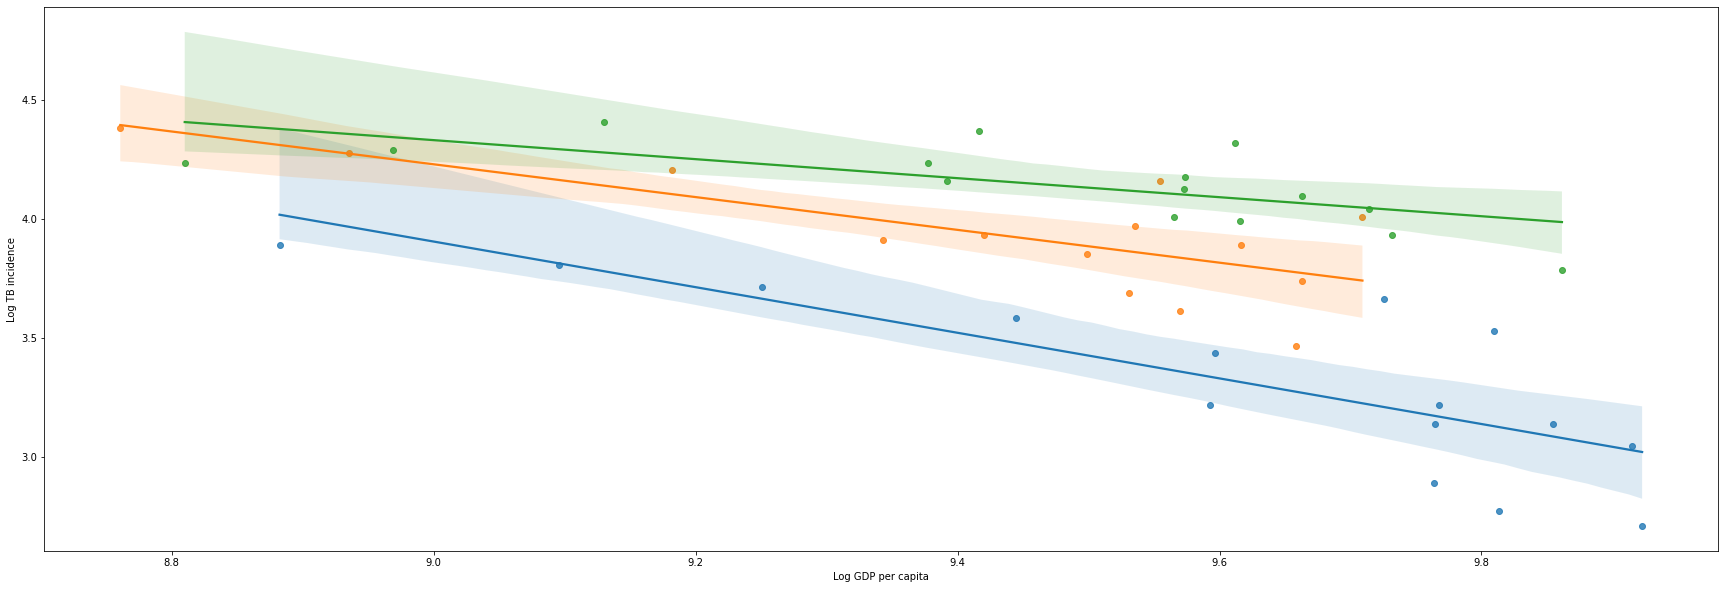

In [61]:
sns.regplot(x='Log GDP per capita', y='Log TB incidence', data=est)
sns.regplot(x='Log GDP per capita', y='Log TB incidence', data=lva)
sns.regplot(x='Log GDP per capita', y='Log TB incidence', data=ltu)

In [62]:
est[['Log GDP per capita',"Log TB incidence"]].corr()
lva[['Log GDP per capita',"Log TB incidence"]].corr()
ltu[['Log GDP per capita',"Log TB incidence"]].corr()

,Log GDP per capita,Log TB incidence
Log GDP per capita,1.000000,-0.679619
Log TB incidence,-0.679619,1.000000


# Conclusion <a name="con"></a>
Estonia, Latvia, and Lithuania experienced significant population demographic impacts as a result of the dissolution of the USSR. The effects were further exacerbated by the 1990s TB epidemic that swept the region. We were able to confirm the effects through observation and analysis using multiple socio-economic and population indicators.

- Population growth, life expectancy, and fertility rates observe a dramatic dip, as expected, in the years following the dissolution of the USSR and the TB epidemic
    - Population growth, otherwise, is constant and follows a trend similar to the EU
    - Life expectancy in the Baltic countries does not recover nearly enough to catch up to the EU
- The Baltic countries follow a very similar GDP and GDP per capita trend, however the Baltics are consistently poorer relative to the EU
    - Compared to the Baltics, EU GDP is on average 20 times higher in 2020